[Ссылка на соревнование Kaggle](https://www.kaggle.com/c/competitive-train-science-predict-future-sales/overview)

In [ ]:
run = 0
if run:
    ! mkdir ~/.kaggle
    ! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    ! chmod 600 ~/.kaggle/kaggle.json
    ! pip install kaggle
    ! kaggle competitions download -c competitive-data-science-predict-future-sales
    ! unzip "items.csv.zip"
    ! unzip "sales_train.csv.zip"
    ! unzip "test.csv.zip"

    # ! pip install catboost
    # ! pip install -U pandas-profiling

In [ ]:

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [ ]:
!kaggle competitions download -c competitive-data-science-predict-future-sales -p kaggle/

  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 50.7MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 68.6MB/s]
 38% 5.00M/13.3M [00:00<00:00, 42.6MB/s]
100% 13.3M/13.3M [00:00<00:00, 65.0MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.96MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 3.11MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 225MB/s]


In [ ]:
!unzip /content/kaggle/sales_train.csv.zip
!unzip /content/kaggle/test.csv.zip
!unzip /content/kaggle/sample_submission.csv.zip
!unzip /content/kaggle/shops.csv.zip
!unzip /content/kaggle/items.csv.zip

Archive:  /content/kaggle/sales_train.csv.zip
  inflating: sales_train.csv         
Archive:  /content/kaggle/test.csv.zip
  inflating: test.csv                
Archive:  /content/kaggle/sample_submission.csv.zip
  inflating: sample_submission.csv   
unzip:  cannot find or open /content/kaggle/shops.csv.zip, /content/kaggle/shops.csv.zip.zip or /content/kaggle/shops.csv.zip.ZIP.
Archive:  /content/kaggle/items.csv.zip
  inflating: items.csv               


# Определения

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as plt
# from sklearn import model_selection
# from sklearn.model_selection import train_test_split
# from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from itertools import product
import pickle

In [ ]:


test =  pd.read_csv ('/content/test.csv' )
sales_train =  pd.read_csv ('/content/sales_train.csv' )
item_categories =  pd.read_csv ('/content/kaggle/item_categories.csv' )
sample_submission =  pd.read_csv ('/content/sample_submission.csv')
shops = pd.read_csv('/content/kaggle/shops.csv')
items = pd.read_csv('/content/items.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [ ]:
sales_train = sales_train[sales_train.item_price<80000]
sales_train = sales_train[sales_train.item_cnt_day<2000]

# EDA

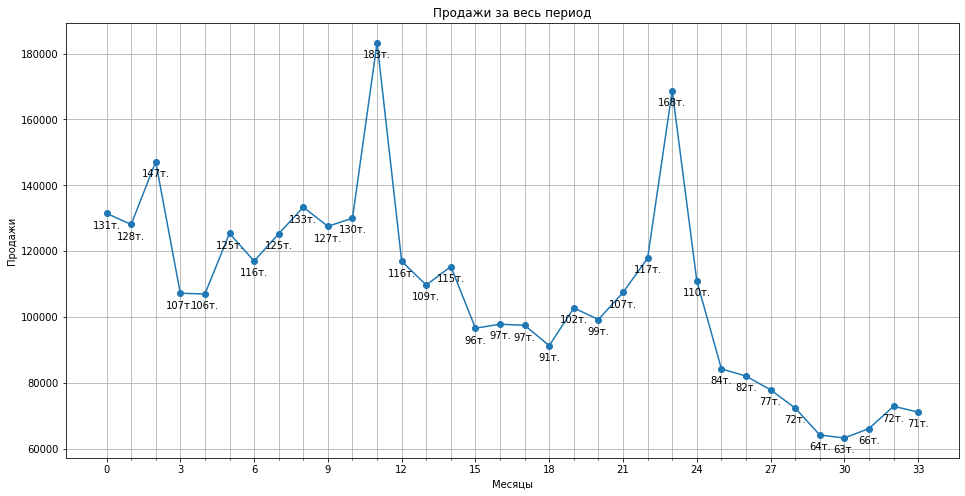

In [ ]:
ts=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()

fig, ax = plt.subplots(figsize=(16, 8))

plt.title('Продажи за весь период')
plt.xlabel('Месяцы')
plt.ylabel('Продажи')

major_ticks = np.arange(0, 34, 3)
minor_ticks = np.arange(0, 34, 1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')

for i in range(34):
    ax.annotate(
                str(int(ts[i] / 1000))+'т.',
                (i, ts[i]),
                textcoords="offset points",
                xytext=(0, -15),
                ha='center',
                )

plt.plot(ts, marker='o')
plt.savefig('sales.png')
plt.show()


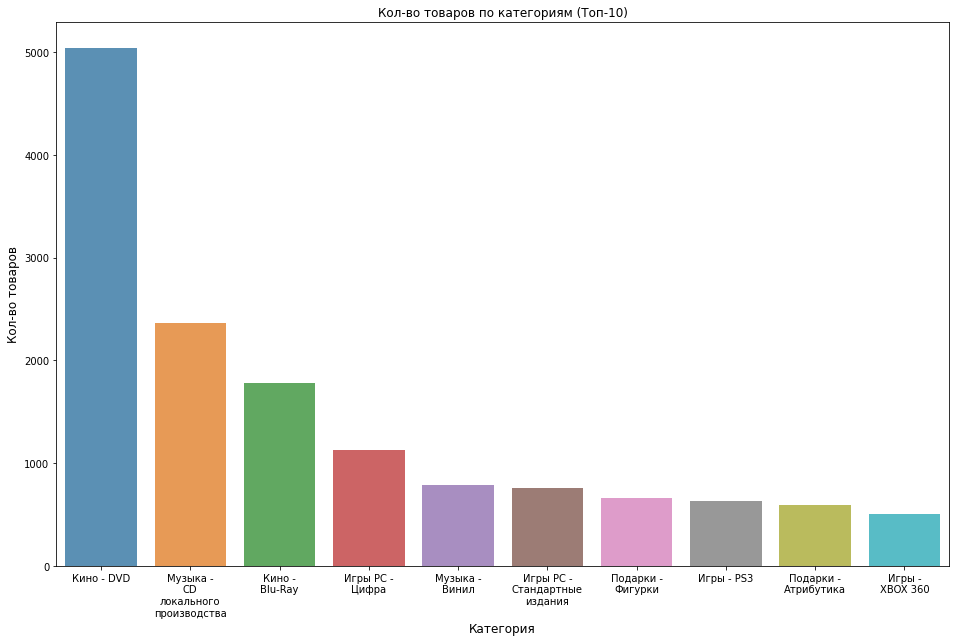

In [ ]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

x = items.merge(item_categories, how='inner')
x = x.groupby(['item_category_name']).count()
x = x.sort_values(by='item_id',ascending=False)
x = x.iloc[0:10].reset_index()


fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x=x.item_category_name, y=x.item_id, alpha=0.8)
plt.title("Кол-во товаров по категориям (Топ-10)")
plt.ylabel('Кол-во товаров', fontsize=12)
plt.xlabel('Категория', fontsize=12, wrap=True)
wrap_labels(ax, 10)
plt.savefig('items_cat.png')
plt.show()


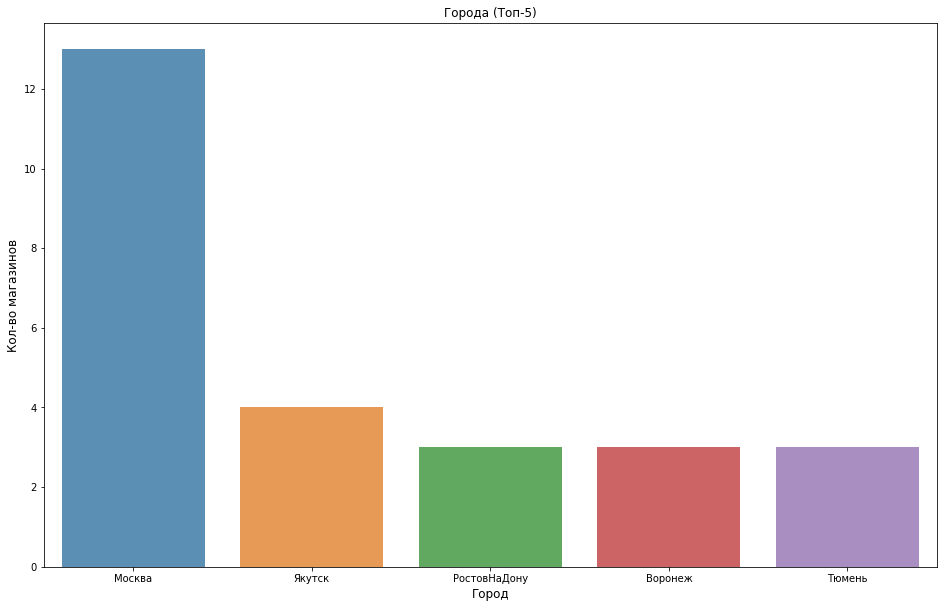

In [ ]:
y = shops.copy()
y = y.groupby(['city']).count()
y = y.sort_values(by='shop_name',ascending=False)
y = y.iloc[0:5].reset_index()

plt.figure(figsize=(16,10))
sns.barplot(x=y.city, y=y.shop_name, alpha=0.8)
plt.title("Города (Топ-5)")
plt.ylabel('Кол-во магазинов', fontsize=12)
plt.xlabel('Город', fontsize=12)
plt.savefig('city.png')
plt.show()


# Feature Engineering

In [ ]:
# Определим таргет
target_col = 'item_cnt_day'

In [ ]:
# all_in_one = sales_train.merge(items, how='inner')
# all_in_one = all_in_one.merge(item_categories, how='inner')
# all_in_one = all_in_one.merge(shops, how='inner')

In [ ]:
# all_in_one_test = test.merge(items, how='inner')
# all_in_one_test = all_in_one_test.merge(shops, how='inner')
# all_in_one_test = all_in_one_test.merge(item_categories, how='inner')

In [ ]:
sales_train.insert(1, "Day", sales_train.date.str.split(pat=".", expand=True).astype('int32')[0])
sales_train.insert(2, "Month", sales_train.date.str.split(pat=".", expand=True).astype('int32')[1])
sales_train.insert(3, "Year", sales_train.date.str.split(pat=".", expand=True).astype('int32')[2])
sales_train.drop(['date'], axis=1, inplace=True)

In [ ]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(all_in_one, title="Games", explorative=True, minimal=False)
# profile.to_file("pricing.html")
# profile

In [ ]:
# # Посмотрим корриляцию с таргетом
# correlations_train = abs(all_in_one.corr()[target_col]).sort_values()
# correlations_train

In [ ]:
item_categories.loc[item_categories.item_category_name == 'Кино - Blu-Ray', 'item_category_name'] = 'Кино - BluRay'

In [ ]:
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
# Если подкатегория равна пустому значению 
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories.drop(['item_category_name', 'split'],axis=1, inplace=True)
item_categories.head()

,item_category_id,type,subtype
0,0,PC,Гарнитуры/Наушники
1,1,Аксессуары,PS2
2,2,Аксессуары,PS3
3,3,Аксессуары,PS4
4,4,Аксессуары,PSP


In [ ]:
#Добавим в тестовый датасет для Нобря 2015 колонку date_block_num c индексом месяцы (34)
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)

In [ ]:
#matrix - матрица которую мы подготавливаем для обучения модели, за счет присоединения признаков и разных датасетов загруженных вначале
matrix = []

for month in sales_train['date_block_num'].unique():
    shops_in_month = sales_train.loc[sales_train['date_block_num']==month, 'shop_id'].unique()
    items_in_month = sales_train.loc[sales_train['date_block_num']==month, 'item_id'].unique()
    matrix.append(np.array(list(product(*[[month], shops_in_month, items_in_month])), dtype='int32'))

# Благодаря функции product перебираем возможные комбинации

matrix = np.vstack(matrix)
matrix = pd.DataFrame(matrix, columns = ['date_block_num','shop_id', 'item_id', ])

In [ ]:
shops_in_month

array([45, 46, 44, 41, 39, 42, 34, 31, 35, 38, 37, 36,  6, 56, 57, 55, 58,
       59, 48, 47, 49, 53, 52, 50, 16, 15, 12, 14, 20, 19, 22, 18,  5,  4,
        2,  3,  9,  7, 10, 28, 26, 25, 24, 21])

In [ ]:
matrix = pd.concat(
    [matrix, test.drop(['ID'], axis=1)],
    ignore_index=True, sort=False, keys= ['date_block_num','shop_id', 'item_id' ]
)
matrix

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
11128045,34,45,18454
11128046,34,45,16188
11128047,34,45,15757
11128048,34,45,19648


In [ ]:
group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price':['last'],'item_cnt_day': ['sum']})
group.reset_index(inplace=True)
group.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_month']

Заполняем колонку проданного товара за месяц - item_cnt_month, если получаем пустое значение то ставим 0

In [ ]:
matrix = pd.merge(matrix, group, on= ['date_block_num','shop_id', 'item_id'], how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) 
                                .astype(np.float16))

In [ ]:
matrix

,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,0,59,22154,999.0,1.0
1,0,59,2552,NaN,0.0
2,0,59,2554,NaN,0.0
3,0,59,2555,NaN,0.0
4,0,59,2564,NaN,0.0
...,...,...,...,...,...
11128045,34,45,18454,NaN,0.0
11128046,34,45,16188,NaN,0.0
11128047,34,45,15757,NaN,0.0
11128048,34,45,19648,NaN,0.0


In [ ]:
matrix = pd.merge(matrix, items, on='item_id', how='left')
matrix = pd.merge(matrix, shops, on='shop_id', how='left')
matrix = pd.merge(matrix, item_categories, on='item_category_id', how='left')
matrix.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,shop_name,city,type,subtype
0,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Ярославль,Кино,BluRay
1,0,59,2552,NaN,0.0,DEEP PURPLE The House Of Blue Light LP,58,"Ярославль ТЦ ""Альтаир""",Ярославль,Музыка,Винил
2,0,59,2554,NaN,0.0,DEEP PURPLE Who Do You Think We Are LP,58,"Ярославль ТЦ ""Альтаир""",Ярославль,Музыка,Винил
3,0,59,2555,NaN,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Ярославль ТЦ ""Альтаир""",Ярославль,Музыка,CD фирменного производства
4,0,59,2564,NaN,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,"Ярославль ТЦ ""Альтаир""",Ярославль,Музыка,Музыкальное видео


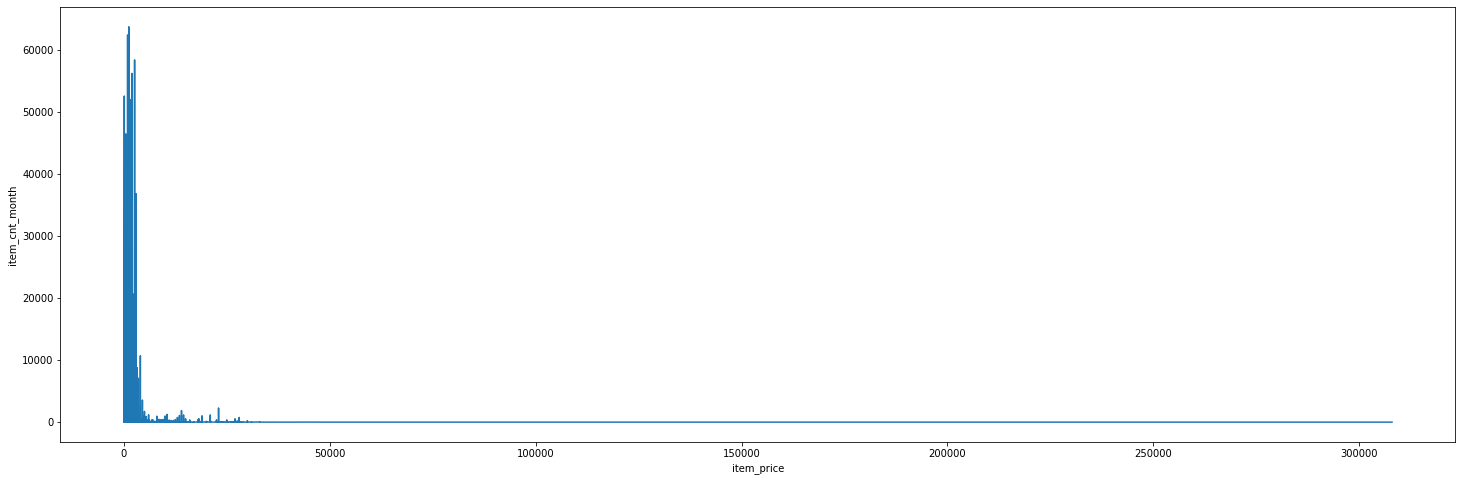

In [ ]:
fig, axes = plt.subplots(figsize=(25,8))
sns.lineplot(data=matrix.groupby(by='item_price').sum().reset_index(), x="item_price", y='item_cnt_month', ax=axes)
plt.savefig('item_cnt_month_item_price.png')
plt.show()

In [ ]:
# Сформируем целевые задержки по последним трём месяцам, за полгода и за год
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [ ]:
matrix.to_csv('matrix.csv', index = False)

## Сдвиги значений по одному и нескольким признакам 

Сдвиг среднемесячных продаж

In [ ]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

Сдвиг среднемесячных продаж по товарам

In [ ]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

Сдвиг среднемесячных продаж по магазинам

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

Сдвиг среднемесячных продаж по категориям товаров

In [ ]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_category_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_category_avg_item_cnt'] = matrix['date_category_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_category_avg_item_cnt')
matrix.drop(['date_category_avg_item_cnt'], axis=1, inplace=True)

Сдвиг среднемесячных продаж по магазинам и категориям товаров

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

Сдвиг среднемесячных продаж по магазинам и типу товаров

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

Сдвиг среднемесячных продаж по магазинам и подтипу товара

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

Сдвиг среднемесячных продаж по городам

In [ ]:
group = matrix.groupby(['date_block_num', 'city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

Сдвиг среднемесячных продаж по городам и товарам

In [ ]:
group = matrix.groupby(['date_block_num', 'item_id', 'city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

Сдвиг среднемесячных продаж по типу товара

In [ ]:
group = matrix.groupby(['date_block_num', 'type']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

Сдвиг среднемесячных продаж по подтипу товара

In [ ]:
group = matrix.groupby(['date_block_num', 'subtype']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_month',
       'item_name', 'item_category_id', 'shop_name', 'city', 'type', 'subtype',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_category_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1'],
 

In [ ]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 35 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int32  
 1   shop_id                               int64  
 2   item_id                               int64  
 3   item_price                            float64
 4   item_cnt_month                        float16
 5   item_name                             object 
 6   item_category_id                      int64  
 7   shop_name                             object 
 8   city                                  object 
 9   type                                  object 
 10  subtype                               object 
 11  item_cnt_month_lag_1                  float16
 12  item_cnt_month_lag_2                  float16
 13  item_cnt_month_lag_3                  float16
 14  item_cnt_month_lag_6                  float16
 15  item_cnt_mont

## Тренд цены

In [ ]:
group = sales_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

In [ ]:
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

Последнии продажи магазина и товара

In [ ]:
# cache = {}
# matrix['item_shop_last_sale'] = -1
# matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
# for idx, row in matrix.iterrows():    
#     key = str(row.item_id)+' '+str(row.shop_id)
#     if key not in cache:
#         if row.item_cnt_month!=0:
#             cache[key] = row.date_block_num
#     else:
#         last_date_block_num = cache[key]
#         matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
#         cache[key] = row.date_block_num 

In [ ]:
# cache = {}
# matrix['item_last_sale'] = -1
# matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
# for idx, row in matrix.iterrows():    
#     key = row.item_id
#     if key not in cache:
#         if row.item_cnt_month!=0:
#             cache[key] = row.date_block_num
#     else:
#         last_date_block_num = cache[key]
#         if row.date_block_num>last_date_block_num:
#             matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
#             cache[key] = row.date_block_num   

Первые продажи магазина и товара

In [ ]:
# matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
# matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

Заполние пустых ячеек связнных с залдержками и проданнами товарами за месяц

In [ ]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [ ]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 43 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int32  
 1   shop_id                               int64  
 2   item_id                               int64  
 3   item_price                            float64
 4   item_cnt_month                        float16
 5   item_name                             object 
 6   item_category_id                      int64  
 7   shop_name                             object 
 8   city                                  object 
 9   type                                  object 
 10  subtype                               object 
 11  item_cnt_month_lag_1                  float16
 12  item_cnt_month_lag_2                  float16
 13  item_cnt_month_lag_3                  float16
 14  item_cnt_month_lag_6                  float16
 15  item_cnt_mont

In [ ]:
# Определение категориальных признаков
cols = matrix.columns
num_cols = matrix._get_numeric_data().columns
cat_features = list(set(cols) - set(num_cols))

5

In [ ]:
# Заменим категориальные признаки NaN на 'missing'
for elem in cat_features:
    if matrix[elem].isna().any():
        matrix[elem] = matrix[elem].fillna('missing')
    if matrix[elem].isna().any():
        matrix[elem] = matrix[elem].fillna('missing')

In [ ]:
matrix.to_pickle('train.pkl')
test.to_pickle('test.pkl')

In [ ]:
%reset -f

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as ctb
import numpy as np
import math
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error as mse

In [ ]:
train = pd.read_pickle('/content/drive/MyDrive/train.pkl')
test = pd.read_pickle('/content/drive/MyDrive/test.pkl')

In [ ]:
# Тренировочная выборка
X_train = train[train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = train[train.date_block_num < 33]['item_cnt_month']
# Валидационная выборка
X_valid = train[train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = train[train.date_block_num == 33]['item_cnt_month']
# Тестовая выборка
X_test = train[train.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
train_pool = Pool(
    X_train,
    label=Y_train,
    cat_features=cat_features)

val_pool = Pool(
    X_valid,
    label=Y_valid,
    cat_features=cat_features)

test_pool = Pool(
    X_test,
    cat_features=cat_features)


In [ ]:
model = CatBoostRegressor(
    #learning_rate=0.75,
    # depth = 10,
    # eval_metric='RMSE',
    # od_pval=0.1,
    # od_wait=30,
    # random_seed=321,
    max_depth=10, 
    loss_function='RMSE',
    n_estimators = 1000,
    eta = 0.3,
    random_seed=123,
    task_type='GPU',
    use_best_model=True,
    )

model.fit(train_pool, eval_set=val_pool)

0:	learn: 1.0144407	test: 0.9407541	best: 0.9407541 (0)	total: 2.1s	remaining: 34m 56s
1:	learn: 0.8810642	test: 0.8434264	best: 0.8434264 (1)	total: 4.45s	remaining: 36m 59s
2:	learn: 0.8045077	test: 0.7947611	best: 0.7947611 (2)	total: 6.8s	remaining: 37m 39s
3:	learn: 0.7604353	test: 0.7777524	best: 0.7777524 (3)	total: 9.16s	remaining: 38m 1s
4:	learn: 0.7359988	test: 0.7619548	best: 0.7619548 (4)	total: 11.6s	remaining: 38m 32s
5:	learn: 0.7189833	test: 0.7507970	best: 0.7507970 (5)	total: 14.3s	remaining: 39m 22s
6:	learn: 0.7082363	test: 0.7477595	best: 0.7477595 (6)	total: 17.1s	remaining: 40m 22s
7:	learn: 0.7015071	test: 0.7433036	best: 0.7433036 (7)	total: 19.8s	remaining: 40m 52s
8:	learn: 0.6803339	test: 0.7454258	best: 0.7433036 (7)	total: 22.4s	remaining: 41m 3s
9:	learn: 0.6761133	test: 0.7421303	best: 0.7421303 (9)	total: 24.7s	remaining: 40m 43s
10:	learn: 0.6707125	test: 0.7426019	best: 0.7421303 (9)	total: 27.3s	remaining: 40m 51s
11:	learn: 0.6672365	test: 0.740885

In [ ]:
import pickle
filename = 'final_model' # name to store model
pickle.dump(model, open(filename, 'wb')) # pickling
!cp /content/final_model /content/drive/MyDrive/

In [ ]:
model.save_model('final_model_ctb')
!cp /content/final_model_ctb /content/drive/MyDrive/

In [ ]:
# loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
Y_pred = model.predict(X_valid)

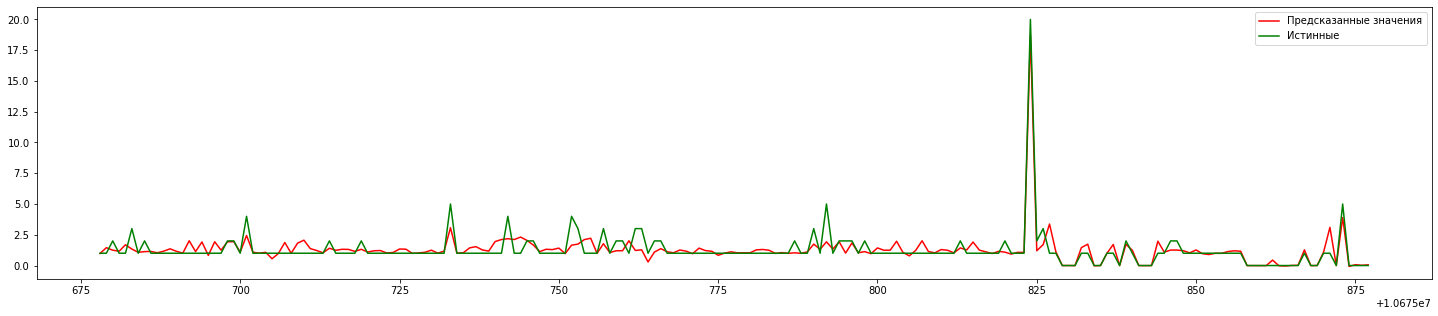

In [ ]:
submission = pd.DataFrame({
    "ID": X_valid.index, 
    "item_cnt_month": Y_pred
})
x = submission['ID'].head(200)
y_pred = submission['item_cnt_month'].head(200)
y_true = Y_valid.head(200)
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)
ax.plot(x, y_pred, label = 'Предсказанные значения', color = 'red')
ax.plot(x, y_true, label = 'Истинные', color = 'green')

ax.legend()

plt.show()

In [ ]:
print(f'MSE на валиционной выборке: {round(mse(Y_valid, Y_pred), 5)}\nRMSE на валиционной выборке: {round(math.sqrt(mse(Y_valid, Y_pred)),5)}')

MSE на валиционной выборке: 0.53834
RMSE на валиционной выборке: 0.73372


In [ ]:
def plot_feature_importance(importance,names,model_type):

  feature_importance = np.array(importance)
  feature_names = np.array(names)

  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  plt.figure(figsize=(20,12))
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  plt.title('Оценка важности признаков ' + model_type)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
  plt.show()

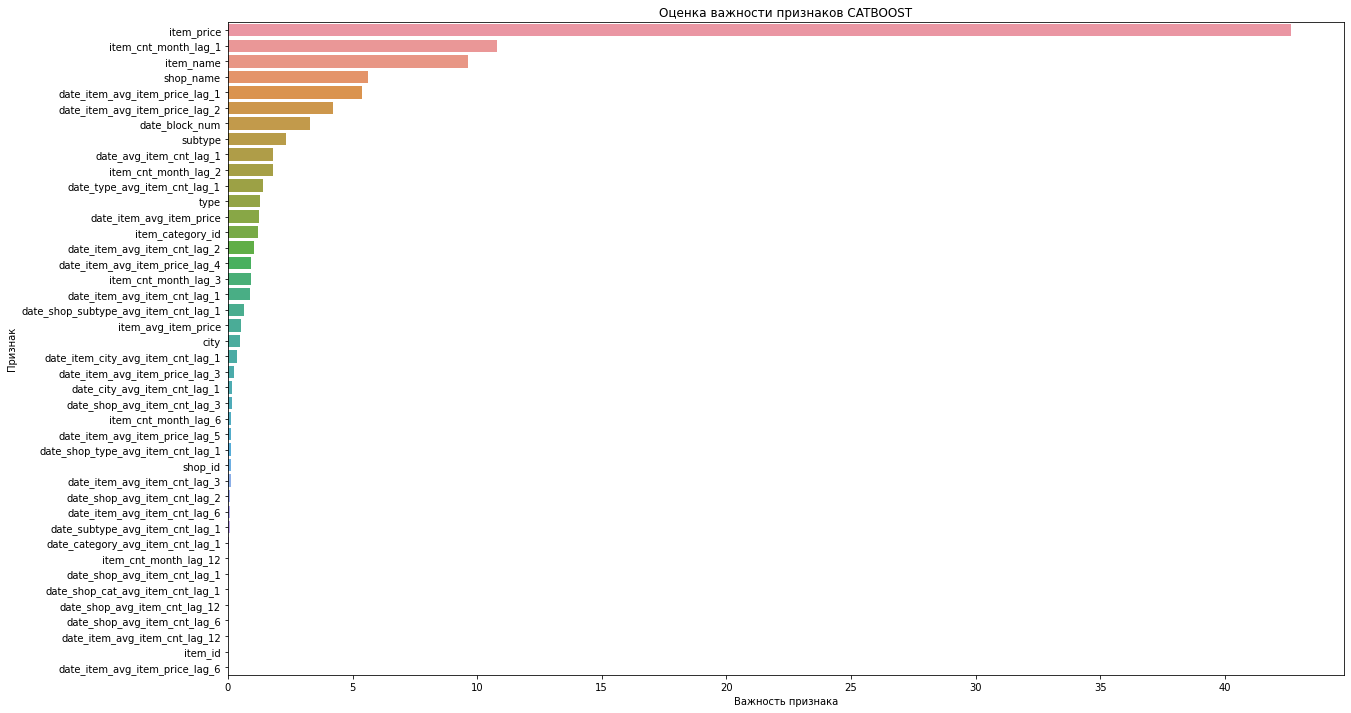

In [ ]:
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST')

In [ ]:
Y_test = model.predict(test_pool)

In [ ]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)
! kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission.csv -m "Final"

100% 5.73M/5.73M [00:00<00:00, 18.5MB/s]
Successfully submitted to Predict Future Sales